### 초기 설정 

In [1]:
# 필요한 library들 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib import rc
from pycaret.classification import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, roc_curve,auc, accuracy_score
from scipy.stats import bartlett
from scipy.stats import levene, ttest_ind

# 한글 설정
font_path = "C:/Users/kangryong/miniconda3/envs/2024-DS/Lib/site-packages/matplotlib/mpl-data/fonts/ttf/NanumGothic.ttf"  # 폰트 경로를 사용자 시스템에 맞게 수정
font_prop = fm.FontProperties(fname=font_path)
rc('font', family=font_prop.get_name())

## 수집한 dataset에 거시경제지표 추가

- 실질 GDP, 명목 GDP feature 추가

In [2]:
df_GDP = pd.read_excel('GDP.xlsx', engine='openpyxl')
df_GDP.iloc[1,0] = "연도"
df_GDP = df_GDP.iloc[:4]
df_GDP.drop(0,axis=0,inplace=True)
df_GDP = df_GDP.set_index("통계표명:")
df_GDP

,국내총생산 및 경제성장률,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53
통계표명:,,,,,,,,,,,,,,,,,,,,,
연도,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
국내총생산(명목GDP),"2,796.6","3,438.0","4,267.7","5,527.3","7,905.0","10,543.6","14,472.8","18,608.1","25,154.5","32,402.3",...,"1,500,819.1","1,562,928.9","1,658,020.4","1,740,779.6","1,835,698.2","1,898,192.6","1,924,498.1","1,940,726.2","2,071,658.0","2,150,575.8"
경제성장률(실질GDP성장률),10.1,10.5,7.2,14.9,9.5,7.8,13.2,12.3,11.0,8.7,...,3.2,3.2,2.8,2.9,3.2,2.9,2.2,-0.7,4.1,2.6


- 실질 환율 feature 추가

In [3]:
df_er = pd.read_excel('주요국 실질실효환율.xlsx', engine='openpyxl')
df_er_K = df_er.drop([f"Unnamed: {i}" for i in [1,3,4,5]],axis=1).T
df_er_K = df_er_K.drop([0,1], axis = 1)
df_er_K

,2,3,4,5,6,7,8,9,10,11,...,360,361,362,363,364,365,366,367,368,369
주요국 실질실효환율,범례명,단위,주기,기간,1994-01,1994-02,1994-03,1994-04,1994-05,1994-06,...,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04
Unnamed: 2,한국(좌축),(2020=100),월,1994-01 ~ 2024-04,116.91,116.33,116.46,115.6,115.1,114.96,...,98.07,96.76,97.22,96.89,98.7,97.51,96.57,96.58,96.74,94.95


- 통화량 M2 feature 추가

In [4]:
df_M2 = pd.read_csv('M2.csv').T
df_M2

,0
통계표,"1.1.3.1.2. M2 상품별 구성내역(평잔, 원계열)"
계정항목,"M2(평잔, 원계열)"
단위,십억원
변환,원자료
1991/02,"151,009.2"
...,...
2023/Q1,"3,804,388.6"
2023/Q2,"3,793,160.0"
2023/Q3,"3,834,922.9"
2023/Q4,"3,890,010.1"


- 기준 금리 feature 추가

In [5]:
df_ir = pd.read_csv('중앙은행_기준금리.csv', encoding='EUC-KR').T
df_ir

,0
국가,대한민국
2009.1/4,2.0
2009.2/4,2.0
2009.3/4,2.0
2009.4/4,2.0
2010.1/4,2.0
2010.2/4,2.0
2010.3/4,2.25
2010.4/4,2.5
2011.1/4,3.0


- 국제수지-경상수지 feature 추가

In [6]:
df_GP = pd.read_html('국제수지-경상수지.xls')[0].set_index("날짜")
df_GP

,원자료
날짜,
1980년 01월,-609.4
1980년 02월,-548.1
1980년 03월,-676.8
1980년 04월,-637.1
1980년 05월,-541.2
...,...
2023년 10월,7437.8
2023년 11월,3890.7
2023년 12월,7414.6


### 재무비율 dataset에 거지경제지표 feature 추가

In [7]:
all_df = pd.read_csv("all_df.csv")
df_er_K = df_er_K.T
df_GDP = df_GDP.T.set_index("연도")

In [8]:
def addingFeature(row):     ## 거시경제지표 feature 추가 함수
    year = int(row['회계년도'])
    exchange_rate =  df_er_K["주요국 실질실효환율"]==f"{year}-12"
    GDP = df_GDP.loc[str(year)].values
    ir = f"{str(year)}.4/4"
    row["실질환율"]= df_er_K[exchange_rate].values[0][1]
    row["실질GDP"] = float(GDP[1].replace(",",""))
    row["명목GDP"] = float(GDP[0].replace(",",""))
    if 2009 <= year < 2019:
        row["기준금리"] = df_ir.loc[ir].values[0] 
    elif year <= 2019:
        row["기준금리"] = 1.25
    else:
        row["기준금리"] = 5.0
    
    row["통화량M2"]=  df_M2.loc[f"{str(year)}/12"].values[0]
    row["국제수지"] = df_GP.loc[f"{str(year)}년 12월"].values[0]
    return row
    
all_df = all_df.apply(addingFeature,axis=1) # 함수 적용
all_df

,회사명,거래소코드,차기부도여부,회계년도,산업코드,소속코드,상장일,감사의견코드,총자본증가율,유형자산증가율,...,EBITDA/금융비용(배),EBITDA/평균발행주식수(백만원),EV/EBITDA(배),산업대분류,실질환율,실질GDP,명목GDP,기준금리,통화량M2,국제수지
0,(주)CMG제약,58820,0,2007.0,32102,5.0,2001/08/31,UQ,120.08,215.25,...,0.00,-104.44,0.000,3,116.34,5.8,1089660.2,1.25,"1,269,522.5",822.4
1,(주)CMG제약,58820,0,2008.0,32102,5.0,2001/08/31,UQ,56.55,55.67,...,-4.56,-221.19,0.133,3,80.21,3.0,1154216.5,1.25,"1,436,298.3",6943.8
2,(주)CMG제약,58820,0,2009.0,32102,5.0,2001/08/31,UQ,-33.92,-8.50,...,-6.80,-443.98,0.000,3,92.31,0.8,1205347.7,2.00,"1,570,027.1",1698.6
3,(주)CMG제약,58820,0,2010.0,32102,5.0,2001/08/31,UQ,5.66,-11.92,...,-5.51,-243.34,0.000,3,92.57,6.8,1322611.2,2.50,"1,682,871.9",-1743.9
4,(주)CMG제약,58820,0,2011.0,32102,5.0,2001/08/31,UQ,14.18,7.86,...,11.24,46.75,18.522,3,91.96,3.7,1388937.2,3.25,"1,756,597.4",1738.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18438,흥구석유(주),24060,0,2015.0,74607,5.0,1994/12/07,UQ,12.89,-0.74,...,15.54,57.08,56.142,7,102.33,2.8,1658020.4,1.50,"2,246,070.1",8042.5
18439,흥구석유(주),24060,0,2016.0,74607,5.0,1994/12/07,UQ,1.39,-5.61,...,10.71,89.90,41.479,7,103.84,2.9,1740779.6,1.25,"2,414,040.9",7361.5
18440,흥구석유(주),24060,0,2017.0,74607,5.0,1994/12/07,UQ,0.98,-0.56,...,9.02,76.50,40.117,7,107.43,3.2,1835698.2,1.50,"2,527,641.3",4486.5
18441,흥구석유(주),24060,0,2018.0,74607,5.0,1994/12/07,UQ,-5.89,-0.36,...,16.83,96.79,25.181,7,106.93,2.9,1898192.6,1.75,"2,699,882.3",4914.4


### 전처리

- t-검정을 통해 1차 feature selection 수행

In [9]:
selected_col = []
drop_col = []

df_0 = all_df[all_df['차기부도여부'] == 0]  # 건실 기업
df_1 = all_df[all_df['차기부도여부'] == 1]  # 부도 기업

for i in all_df.columns[1:]:
    try:
        ser_1 = df_0[i].astype(float)
        ser_2 = df_1[i].astype(float)

        lresult = np.round(levene(ser_1, ser_2)[1], 3)
        if lresult < 0.05:
            if ttest_ind(ser_1, ser_2)[1] < 0.05:
                selected_col.append(i)
            else:
                drop_col.append(i)
        else:
            drop_col.append(i)
    except ValueError:
        # 숫자 타입으로 변환 불가능한 경우 드롭
        drop_col.append(i)

In [10]:
drop_col = [col for col in drop_col if col != '차기부도여부'] # 차기부도여부 column이 drop되지 않게 하기

df = all_df.drop(columns=drop_col)
df

,회사명,차기부도여부,회계년도,산업코드,소속코드,자기자본증가율,종업원1인당 인건비증가율,총자본사업이익률,총자본영업이익률,총자본순이익률,...,총자본투자효율,인건비(백만원),종업원1인당 부가가치(백만원).1,총자본투자효율.1,종업원수,PBR(Price book-value ratio)(최고),EBITDA/평균발행주식수(백만원),산업대분류,실질환율,명목GDP
0,(주)CMG제약,0,2007.0,32102,5.0,193.28,-89.37,-5.80,-8.31,-5.55,...,-1.69,839.34,-3.32,-1.69,112.0,13.08,-104.44,3,116.34,1089660.2
1,(주)CMG제약,0,2008.0,32102,5.0,19.57,177.46,-12.32,-13.37,-16.46,...,-2.66,2786.26,-6.85,-2.66,134.0,4.07,-221.19,3,80.21,1154216.5
2,(주)CMG제약,0,2009.0,32102,5.0,-61.98,48.45,-29.69,-30.14,-63.34,...,-50.50,3673.20,-96.91,-50.50,119.0,11.44,-443.98,3,92.31,1205347.7
3,(주)CMG제약,0,2010.0,32102,5.0,82.10,-0.91,-31.70,-31.74,-32.57,...,-1.87,3945.55,-3.50,-1.87,129.0,2.54,-243.34,3,92.57,1322611.2
4,(주)CMG제약,0,2011.0,32102,5.0,6.72,-24.54,2.85,2.70,-4.89,...,13.77,3115.91,28.10,13.77,135.0,3.31,46.75,3,91.96,1388937.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18438,흥구석유(주),0,2015.0,74607,5.0,3.11,7.13,0.79,0.63,3.98,...,10.04,3353.12,79.15,10.04,99.0,0.74,57.08,7,102.33,1658020.4
18439,흥구석유(주),0,2016.0,74607,5.0,1.39,3.41,1.35,1.23,2.77,...,8.84,3362.28,72.85,8.84,96.0,0.92,89.90,7,103.84,1740779.6
18440,흥구석유(주),0,2017.0,74607,5.0,0.83,6.10,0.97,0.94,2.60,...,8.80,3455.91,75.61,8.80,93.0,0.77,76.50,7,107.43,1835698.2
18441,흥구석유(주),0,2018.0,74607,5.0,0.99,12.14,1.54,1.41,3.06,...,9.80,3500.30,87.78,9.80,84.0,0.97,96.79,7,106.93,1898192.6


- 부도여부가 1인 기업들을 보면, 부도 전 회계년도의 부도 여부는 0으로 돼있다. 이 상태로 train, test set 분류하면 회사명이 겹쳐 분석이 이상하게 될 수 있다. 따라서 중복되는 회사명을 제거하였다.

In [11]:
# 중복 기업명 제거
broken = df[df['차기부도여부'] == 1]['회사명'].unique() # 부도 기업 회사명
df = df[~((df['회사명'].isin(broken)) & (df['차기부도여부'] == 0))] # 부도가 2010년 발생했다면, 2007~2009년의 해당 회사명 data 부도 여부는 0이므로, 0인 경우를 제거해 깔끔한 부도 기업 생성

# 회사명, 회계년도 등 분석에 사용하지 않는 feature 제거
df = df.drop(columns=['회사명', '소속코드', '산업코드', '회계년도'])

# target : '차기부도여부' column
X = df.drop(columns=['차기부도여부'])
y = df['차기부도여부']

- t-검정 이후에도 칼럼의 min, max차이가 커서, 극단치 조절을 위해 min-max 정규화를 적용하였다.

In [12]:
# 데이터셋에 min-max 정규화 적용
minmax = MinMaxScaler() # min-max 정규화 함수
X_minmax = minmax.fit_transform(X) # 분석할 column에 적용

### 모델링
- 모든 random_state = 1로 통일

In [13]:
# train, test data split
X_train, X_test, y_train, y_test = train_test_split(X_minmax, y, test_size=0.2, random_state=1, stratify=y)

### Data Imbalance

Text(0.5, 1.0, '건실 기업 vs 부도 기업 수')

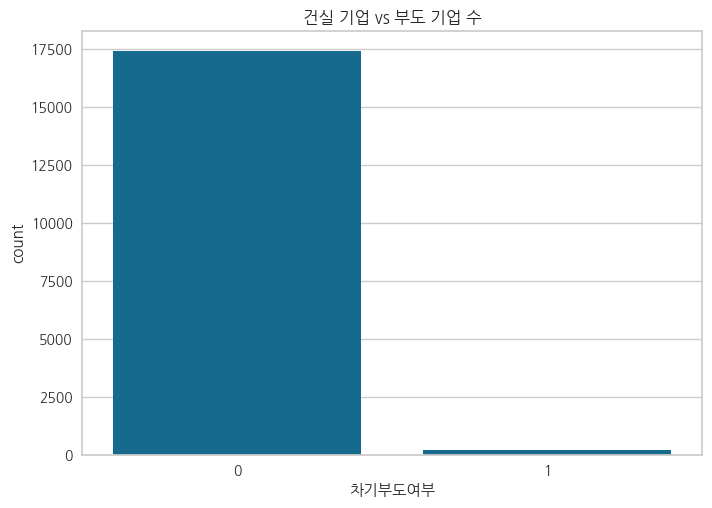

In [14]:
sns.countplot(data=df, x='차기부도여부')
plt.title('건실 기업 vs 부도 기업 수')

- Data Imbalance가 너무 심하다. 부도율이 거의 1% 수준이라 이대로 진행하면 모델 성능이 좋을 수가 없다.
- 따라서 Oversampling 기법인 SMOTE를 사용하고, class_weight='balanced'를 통해 가중치를 조정하였다.

Text(0.5, 1.0, '건실 기업 vs 부도 기업 수')

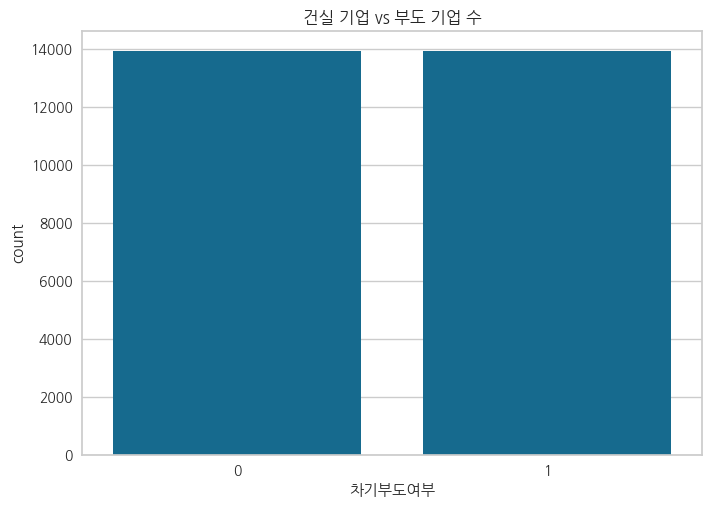

In [15]:
smote = SMOTE(random_state=1) # Oversampling 적용 -> 부도 기업과 건실 기업 비율 맞추기
X_train, y_train = smote.fit_resample(X_train, y_train) # SMOTE 적용

model = LogisticRegression(class_weight='balanced', random_state=1) # 가중치 조절
model.fit(X_train, y_train) # Logistic Regression 모델 적용

# 데이터 불균형 해결됐는 지 확인
sns.countplot(x=y_train)
plt.title('건실 기업 vs 부도 기업 수')

- Data Imbalance 문제가 해결된 걸 볼 수 있다!

#### model 적용

In [16]:
y_pred = model.predict_proba(X_test)[:, 1]                  # Logistic Regression 적용
y_pred = (y_pred >= 0.5).astype(int)  # 0.5 이상이면 1 (부도 기업), 미만이면 0(건실 기업)

#### 성능 확인

Text(0, 0.5, '성능')

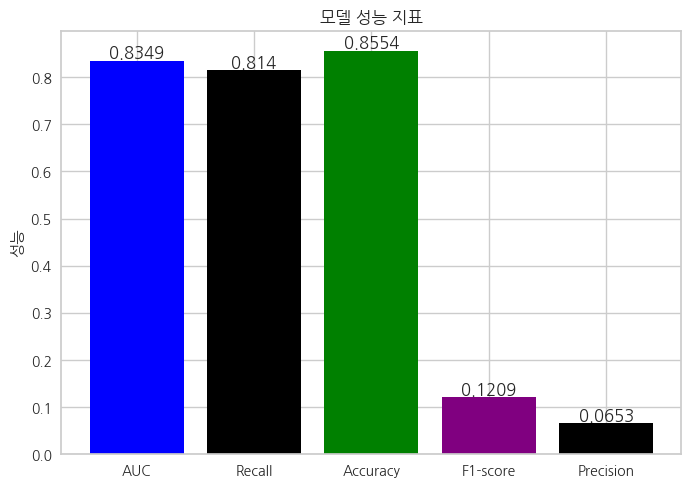

In [17]:
# AUC 성능
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Precision 성능
precision = precision_score(y_test, y_pred)

# Recall 성능
recall = recall_score(y_test, y_pred)

# F1 성능
f1 = f1_score(y_test, y_pred)

# Accuracy 성증
accuracy = accuracy_score(y_test, y_pred)

score = {'AUC' : roc_auc, 'Recall' : recall, 'Accuracy' : accuracy, 'F1-score' : f1, 'Precision' : precision}
metrics = list(score.keys()) # 성능 이름
scores = list(score.values()) # 성능 점수

# 그래프 설정
fig, ax = plt.subplots()

# barplot 생성
bars = ax.bar(metrics, scores, color=['blue', 'black', 'green', 'purple', 'black'])

# 각 bar에 소수점 4자리까지 값 표시
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

# 그래프 제목과 축 레이블 설정
ax.set_title('모델 성능 지표')
ax.set_ylabel('성능')

Text(0, 0.5, 'Feature')

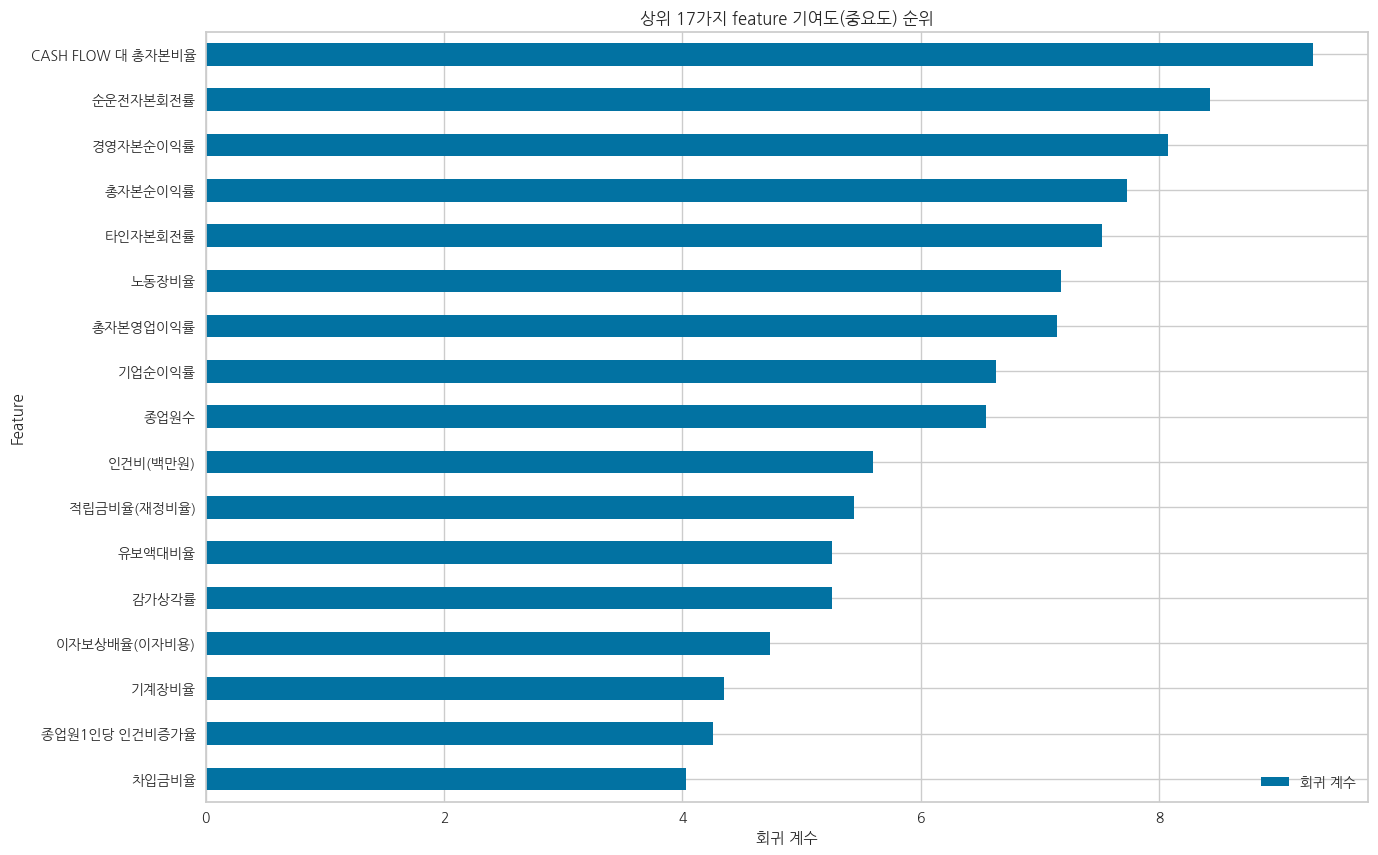

In [18]:
# 모델의 회귀 계수 => model에 대한 각 feature 별 기여도, 중요도
model_coefficient = model.coef_[0] 

# 각 feature 별 회귀 계수의 절대값 dataframe
df_features = pd.DataFrame({'Feature': X.columns, '회귀 계수': np.abs(model_coefficient)})

# 회귀 계수 내림차순으로 정렬
df_features = df_features.sort_values('회귀 계수', ascending=True)

# 상위 17개 칼럼 선택
df_features_top_17 = df_features.tail(17)

# 시각화
df_features_top_17.plot(x='Feature', y='회귀 계수', kind='barh', figsize=(15, 10))
plt.title('상위 17가지 feature 기여도(중요도) 순위')
plt.xlabel('회귀 계수')
plt.ylabel('Feature')

In [19]:
df_features_top_17

,Feature,회귀 계수
35,차입금비율,4.032935
1,종업원1인당 인건비증가율,4.253284
48,기계장비율,4.347370
36,이자보상배율(이자비용),4.735614
15,감가상각률,5.252164
38,유보액대비율,5.253477
18,적립금비율(재정비율),5.437873
50,인건비(백만원),5.598333
53,종업원수,6.543162
9,기업순이익률,6.633710


- 이렇게 뽑은 17가지 feature로 2차 feature selection을 진행했다.

## 최종 모델링

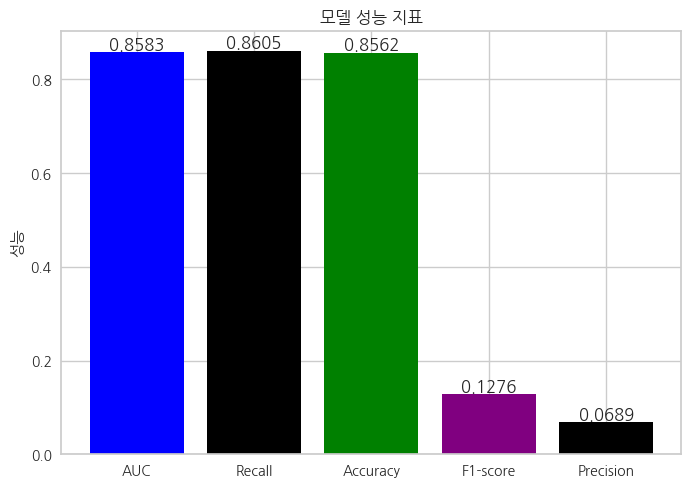

In [20]:
df = pd.read_csv('feature_selection.csv')
df = df[['회사명', 'CASH FLOW 대 총자본비율', '순운전자본회전률', '총자본순이익률', '경영자본순이익률', '노동장비율',
        '기업순이익률', '총자본영업이익률', '타인자본회전률', '종업원수', '유보액대비율', '인건비(백만원)', '기계장비율', '감가상각률',
        '종업원1인당 인건비증가율', '이자보상배율(이자비용)', '자기자본순이익률', '차입금비율', '차기부도여부']]
# 중복 기업명 제거
broken = df[df['차기부도여부'] == 1]['회사명'].unique() # 부도 기업 회사명
df = df[~((df['회사명'].isin(broken)) & (df['차기부도여부'] == 0))] # 부도가 2010년 발생했다면, 2007~2009년의 해당 회사명 data 부도 여부는 0이므로, 0인 경우를 제거해 깔끔한 부도 기업 생성

df = df.drop(columns=['회사명'])


# 회사명, 회계년도 등 분석에 사용하지 않는 feature 제거
# target : '차기부도여부' column
X = df.drop(columns=['차기부도여부'])
y = df['차기부도여부']


# 데이터셋에 min-max 정규화 적용
minmax = MinMaxScaler() # min-max 정규화 함수
X_minmax = minmax.fit_transform(X) # 분석할 column에 적용
# target : '차기부도여부' column
X = df.drop(columns=['차기부도여부'])
y = df['차기부도여부']

# 데이터셋에 min-max 정규화 적용
minmax = MinMaxScaler() # min-max 정규화 함수
X_minmax = minmax.fit_transform(X) # 분석할 column에 적용
# train, test data split
X_train, X_test, y_train, y_test = train_test_split(X_minmax, y, test_size=0.2, random_state=1, stratify=y)
smote = SMOTE(random_state=1) # Oversampling 적용 -> 부도 기업과 건실 기업 비율 맞추기
X_train, y_train = smote.fit_resample(X_train, y_train) # SMOTE 적용

model = LogisticRegression(class_weight='balanced', random_state=1) # 가중치 조절
model.fit(X_train, y_train) # Logistic Regression 모델 적용

y_pred = model.predict_proba(X_test)[:, 1]                  # Logistic Regression 적용
y_pred = (y_pred >= 0.5).astype(int)  # 0.5 이상이면 1 (부도 기업), 미만이면 0(건실 기업)


# AUC 성능
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Precision 성능
precision = precision_score(y_test, y_pred)

# Recall 성능
recall = recall_score(y_test, y_pred)

# F1 성능
f1 = f1_score(y_test, y_pred)

# Accuracy 성증
accuracy = accuracy_score(y_test, y_pred)

score = {'AUC' : roc_auc, 'Recall' : recall, 'Accuracy' : accuracy, 'F1-score' : f1, 'Precision' : precision}
metrics = list(score.keys()) # 성능 이름
scores = list(score.values()) # 성능 점수

# 그래프 설정
fig, ax = plt.subplots()

# barplot 생성
bars = ax.bar(metrics, scores, color=['blue', 'black', 'green', 'purple', 'black'])

# 각 bar에 소수점 4자리까지 값 표시
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

# 그래프 제목과 축 레이블 설정
ax.set_title('모델 성능 지표')
ax.set_ylabel('성능')
plt.savefig('1.png')



- 성능이 향상된 것을 볼 수 있다.

### + 아무 기법 적용 X ver. 성능

Text(0, 0.5, '성능')

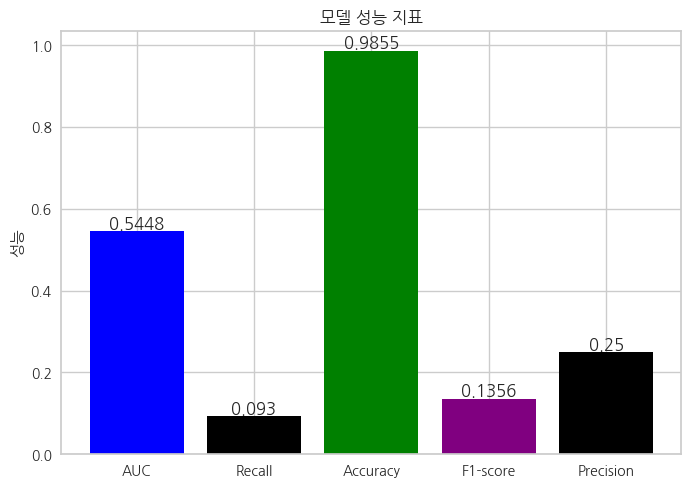

In [21]:
# train, test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

model = LogisticRegression(random_state=1) # 가중치 조절
model.fit(X_train, y_train) # Logistic Regression 모델 적용

y_pred = model.predict_proba(X_test)[:, 1]                  # Logistic Regression 적용
y_pred = (y_pred >= 0.5).astype(int)  # 0.5 이상이면 1 (부도 기업), 미만이면 0(건실 기업)

# AUC 성능
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Precision 성능
precision = precision_score(y_test, y_pred)

# Recall 성능
recall = recall_score(y_test, y_pred)

# F1 성능
f1 = f1_score(y_test, y_pred)

# Accuracy 성증
accuracy = accuracy_score(y_test, y_pred)

score = {'AUC' : roc_auc, 'Recall' : recall, 'Accuracy' : accuracy, 'F1-score' : f1, 'Precision' : precision}
metrics = list(score.keys()) # 성능 이름
scores = list(score.values()) # 성능 점수

# 그래프 설정
fig, ax = plt.subplots()

# barplot 생성
bars = ax.bar(metrics, scores, color=['blue', 'black', 'green', 'purple', 'black'])

# 각 bar에 소수점 4자리까지 값 표시
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

# 그래프 제목과 축 레이블 설정
ax.set_title('모델 성능 지표')
ax.set_ylabel('성능')

### + 외부 도메인 지식으로 2차 feature selection 후 모델링 ver. 성능

Text(0, 0.5, '성능')

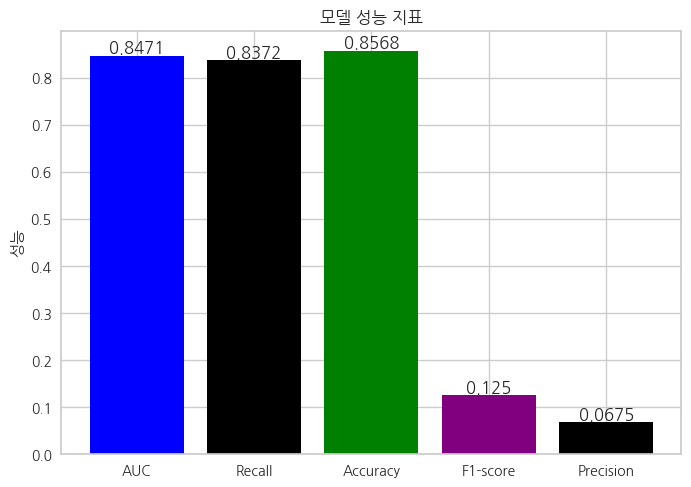

In [22]:
df = pd.read_csv('feature_selection.csv')
df = df[['회사명', '단기차입금 대 총차입금비율' ,'CASH FLOW 대 총자본비율', '사내유보 대 자기자본비율',
        '자기자본증가율', '기계장비율', '종업원1인당 인건비증가율', '종업원1인당 인건비(백만원)',
        '인건비(백만원)', '총자본영업이익률', '차입금비율', '이자보상배율(이자비용)', '비유동부채비율',
        '유동부채비율', '부채비율', '기업순이익률', '순운전자본비율', '차기부도여부']]
# 중복 기업명 제거
broken = df[df['차기부도여부'] == 1]['회사명'].unique() # 부도 기업 회사명
df = df[~((df['회사명'].isin(broken)) & (df['차기부도여부'] == 0))] # 부도가 2010년 발생했다면, 2007~2009년의 해당 회사명 data 부도 여부는 0이므로, 0인 경우를 제거해 깔끔한 부도 기업 생성

df = df.drop(columns=['회사명'])


# 회사명, 회계년도 등 분석에 사용하지 않는 feature 제거
# target : '차기부도여부' column
X = df.drop(columns=['차기부도여부'])
y = df['차기부도여부']


# 데이터셋에 min-max 정규화 적용
minmax = MinMaxScaler() # min-max 정규화 함수
X_minmax = minmax.fit_transform(X) # 분석할 column에 적용
# target : '차기부도여부' column
X = df.drop(columns=['차기부도여부'])
y = df['차기부도여부']

# 데이터셋에 min-max 정규화 적용
minmax = MinMaxScaler() # min-max 정규화 함수
X_minmax = minmax.fit_transform(X) # 분석할 column에 적용
# train, test data split
X_train, X_test, y_train, y_test = train_test_split(X_minmax, y, test_size=0.2, random_state=1, stratify=y)
smote = SMOTE(random_state=1) # Oversampling 적용 -> 부도 기업과 건실 기업 비율 맞추기
X_train, y_train = smote.fit_resample(X_train, y_train) # SMOTE 적용

model = LogisticRegression(class_weight='balanced', random_state=1) # 가중치 조절
model.fit(X_train, y_train) # Logistic Regression 모델 적용

y_pred = model.predict_proba(X_test)[:, 1]                  # Logistic Regression 적용
y_pred = (y_pred >= 0.5).astype(int)  # 0.5 이상이면 1 (부도 기업), 미만이면 0(건실 기업)


# AUC 성능
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Precision 성능
precision = precision_score(y_test, y_pred)

# Recall 성능
recall = recall_score(y_test, y_pred)

# F1 성능
f1 = f1_score(y_test, y_pred)

# Accuracy 성증
accuracy = accuracy_score(y_test, y_pred)

score = {'AUC' : roc_auc, 'Recall' : recall, 'Accuracy' : accuracy, 'F1-score' : f1, 'Precision' : precision}
metrics = list(score.keys()) # 성능 이름
scores = list(score.values()) # 성능 점수

# 그래프 설정
fig, ax = plt.subplots()

# barplot 생성
bars = ax.bar(metrics, scores, color=['blue', 'black', 'green', 'purple', 'black'])

# 각 bar에 소수점 4자리까지 값 표시
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

# 그래프 제목과 축 레이블 설정
ax.set_title('모델 성능 지표')
ax.set_ylabel('성능')